# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")


header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T

### Phenotypes

#### Cell Viability:

In [3]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [4]:
ncl = 2

In [5]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

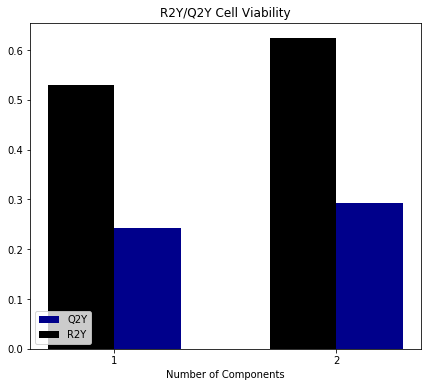

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

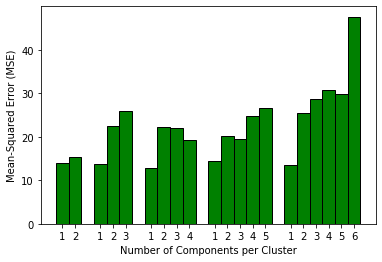

In [7]:
fig, ax = plt.subplots(1, 1)
plotKmeansPLSR_GridSearch(ax, data, Y_cv)

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [8]:
ncl, ncomp = 2, 2

### 2.1 With CV Strategy 1:

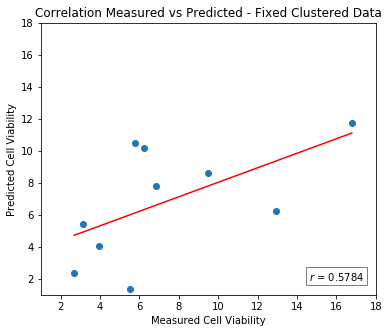

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [10]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

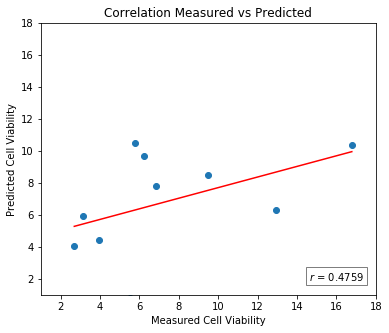

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

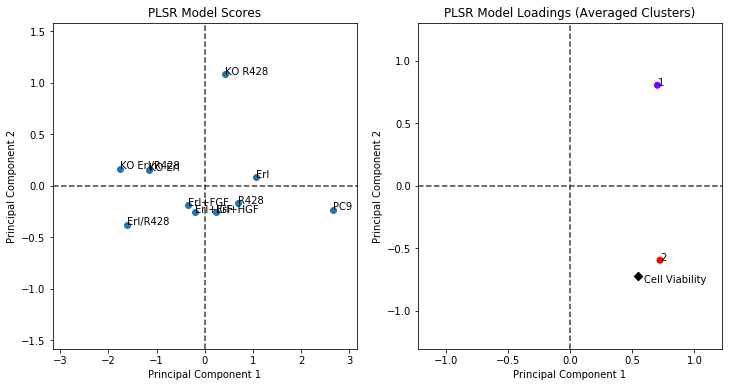

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

plotScoresLoadings(ax, kmeans_plsr, data, Y_cv, ncl, colors_)

In [13]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Condition_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,Condition_Cluster_2,pos_Cluster_2
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p
1,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Q9Y2X7,Y383-p
2,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Q8N4X5,Y56-p
3,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,"Actin, cytoplasmic 1",LTERGySFTTT,P60709,Y198-p
4,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p,Activated CDC42 kinase 1,VSSTHyYLLPE,Q07912,Y859-p
...,...,...,...,...,...,...,...,...
200,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,P30530,Y759-p,NaN,NaN,NaN,NaN
201,Tyrosine-protein phosphatase non-receptor type 11,QNTGDyYDLYG,Q06124,Y62-p,NaN,NaN,NaN,NaN
202,Vasodilator-stimulated phosphoprotein,SRVQIyHNPTA,P50552,Y39-p,NaN,NaN,NaN,NaN
203,Vigilin,INRMDyVEINI,Q00341,Y437-p,NaN,NaN,NaN,NaN


#### Cluster Averages across Conditions

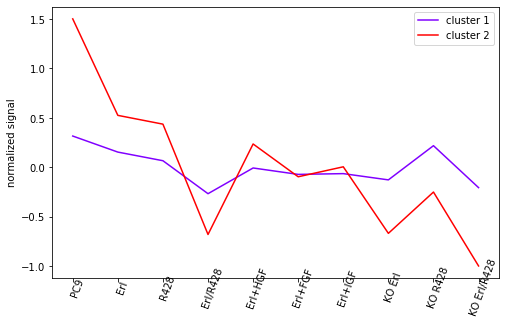

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, kmeans_plsr, colors_, mixed=False)